In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import torch
import cv2
import sys
import json
from PIL import Image
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

from dataset import *

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617
Pytorch Version:[1.7.1]
device:[cuda:0]


In [3]:
sys.path.append('/opt/ml/my_code/src')
from augmix import imbalence_aug, augmix_search

# Semantic Segmentation Augmentation
- https://albumentations.ai/docs/examples/example_kaggle_salt/#non-rigid-transformations-elastictransform-griddistortion-opticaldistortion

In [4]:
# to visualize

COLORS =[
        [129, 236, 236],
        [2, 132, 227],
        [232, 67, 147],
        [255, 234, 267],
        [0, 184, 148],
        [85, 239, 196],
        [48, 51, 107],
        [255, 159, 26],
        [255, 204, 204],
        [179, 57, 57],
        [248, 243, 212],
    ]

COLORS = np.vstack([[0, 0, 0], COLORS]).astype('uint8')  # (12, 3)으로 쌓아줌
COLORS.shape

(12, 3)

In [5]:
dataset_path = '/opt/ml/input/data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'

In [6]:
IMAGE_SIZE = 256

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Oneof 사용
# grid_transform = A.Compose([
#         A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#         A.OneOf([
#             A.ElasticTransform(p=1),
#             A.GridDistortion(p=1)
#         ], p=0.4),
#         A.Normalize(),
#         ToTensorV2()
# ])

# Normal image
trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ToTensorV2()
])

# seong-bae transform
sb_trfm = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
])

elastic_trfm = A.Compose([
        A.ElasticTransform(alpha=40, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        ToTensorV2()
])

grid_distort_trfm = A.Compose([
        A.GridDistortion(p=1),
        ToTensorV2()
])

random_grid_shuffle_trfm = A.Compose([
        A.RandomGridShuffle(p=1),
        ToTensorV2()
])

clahe_trfm = A.Compose([
    A.CLAHE(p=1),
    ToTensorV2()
])

random_resize_trfm = A.Compose([
    A.RandomSizedCrop(min_max_height=(150, 200), height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
    ToTensorV2()
])

# rotate 30 이상 넘어가면 병이 거꾸로 ?!
rotate_trfm = A.Compose([
    A.Rotate(limit=30, p=1),
    ToTensorV2()
])

cutout_trfm = A.Compose([
      A.Cutout(num_holes=4, max_h_size=20, max_w_size=20,p=1),
      ToTensorV2()
])

In [8]:
dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=trfm)

loading annotations into memory...
Done (t=3.78s)
creating index...
index created!


In [9]:
def show_image(image, mask, info, name=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
    ax1.imshow(image)
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(info['file_name']), fontsize = 15)

    ax2.imshow(mask)
    ax2.grid(False)
    if name != None:
        ax2.set_title(name + " Mask : {}".format(info['file_name']), fontsize = 15)
    else:
        ax2.set_title("Mask : {}".format(info['file_name']), fontsize = 15)

In [10]:
image, label, info = dataset[0]
image.shape, label.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [11]:
image = image.permute([1, 2, 0])

label_saved = label
label = label.detach().cpu().numpy()
label = list(label.astype(np.uint8))

mask = COLORS[label]

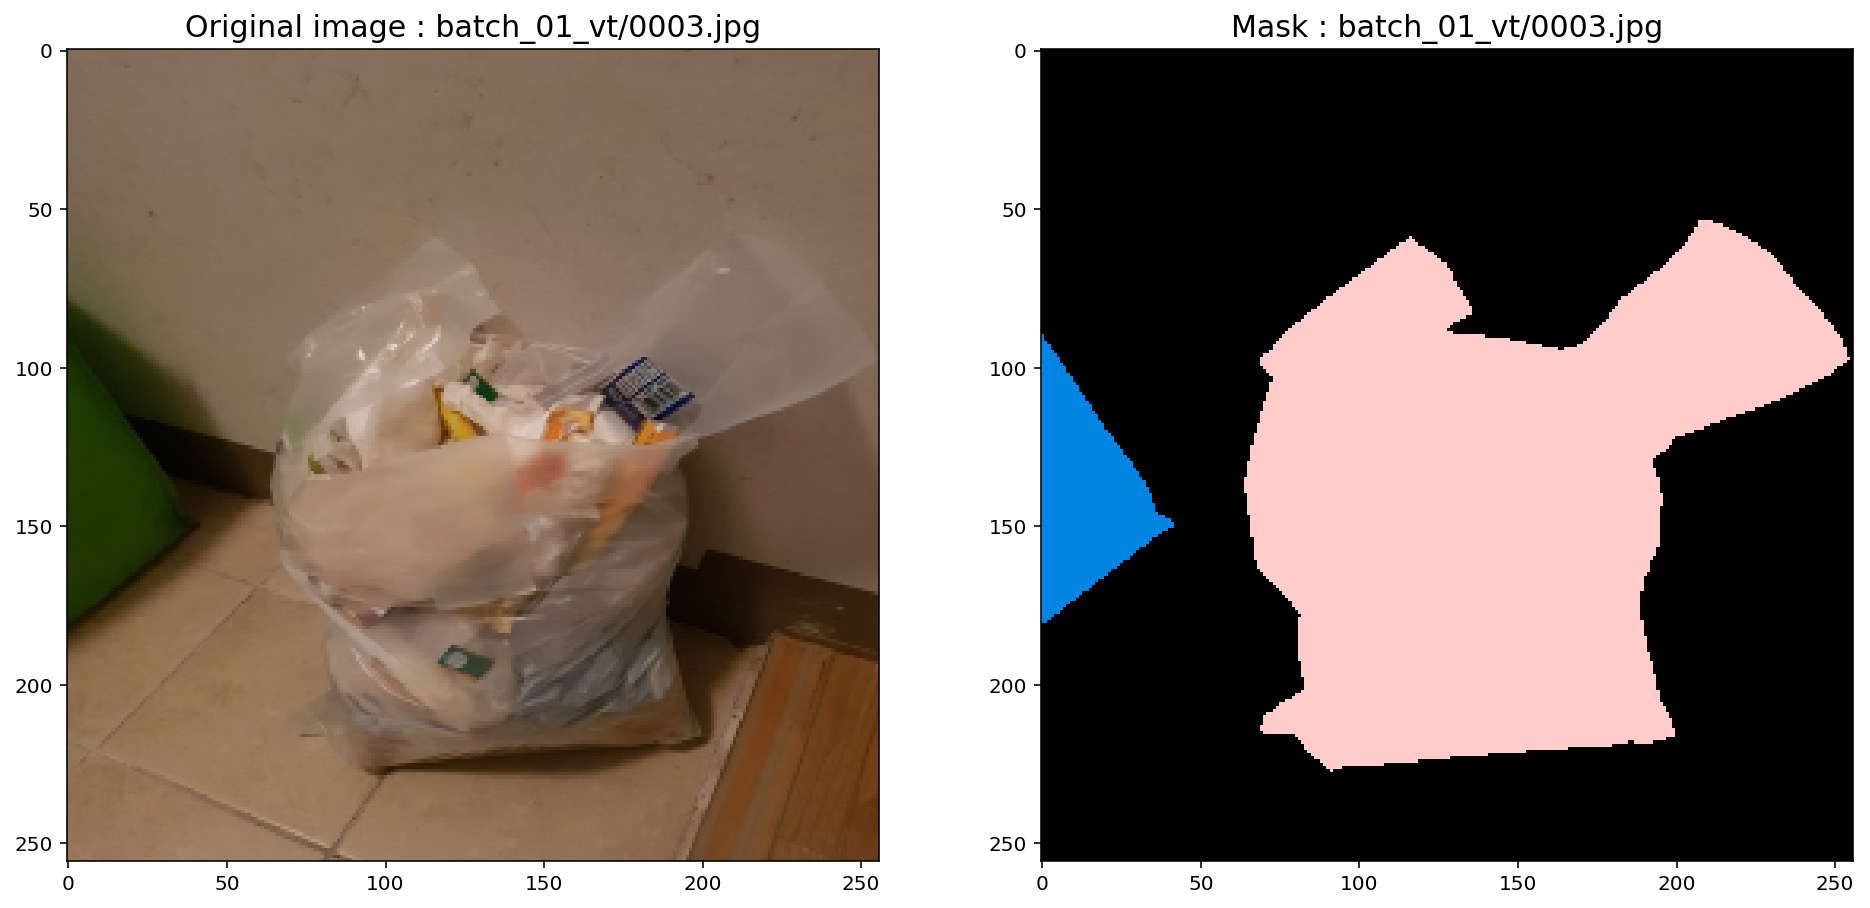

In [12]:
show_image(image, mask, info)

In [13]:
# sungbae trasnform
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
augmix_data=np.load('/opt/ml/my_code/aug.npy')

In [46]:
# augmix_data.item()  # array에 있는 것을 뽑아내줌

In [27]:
dataset = AugmixDataLoader(data_dir=train_path, mode='train', transform=trfm, augmix=augmix_data.item(), augmix_prob=1)

loading annotations into memory...
Done (t=4.63s)
creating index...
index created!


In [39]:
img, msk, info = dataset[0]

In [40]:
img = img.permute([1, 2, 0])
msk = msk.detach().cpu().numpy()
msk = list(msk.astype(np.uint8))

msk = COLORS[msk]

In [41]:
msk.shape

(256, 256, 3)

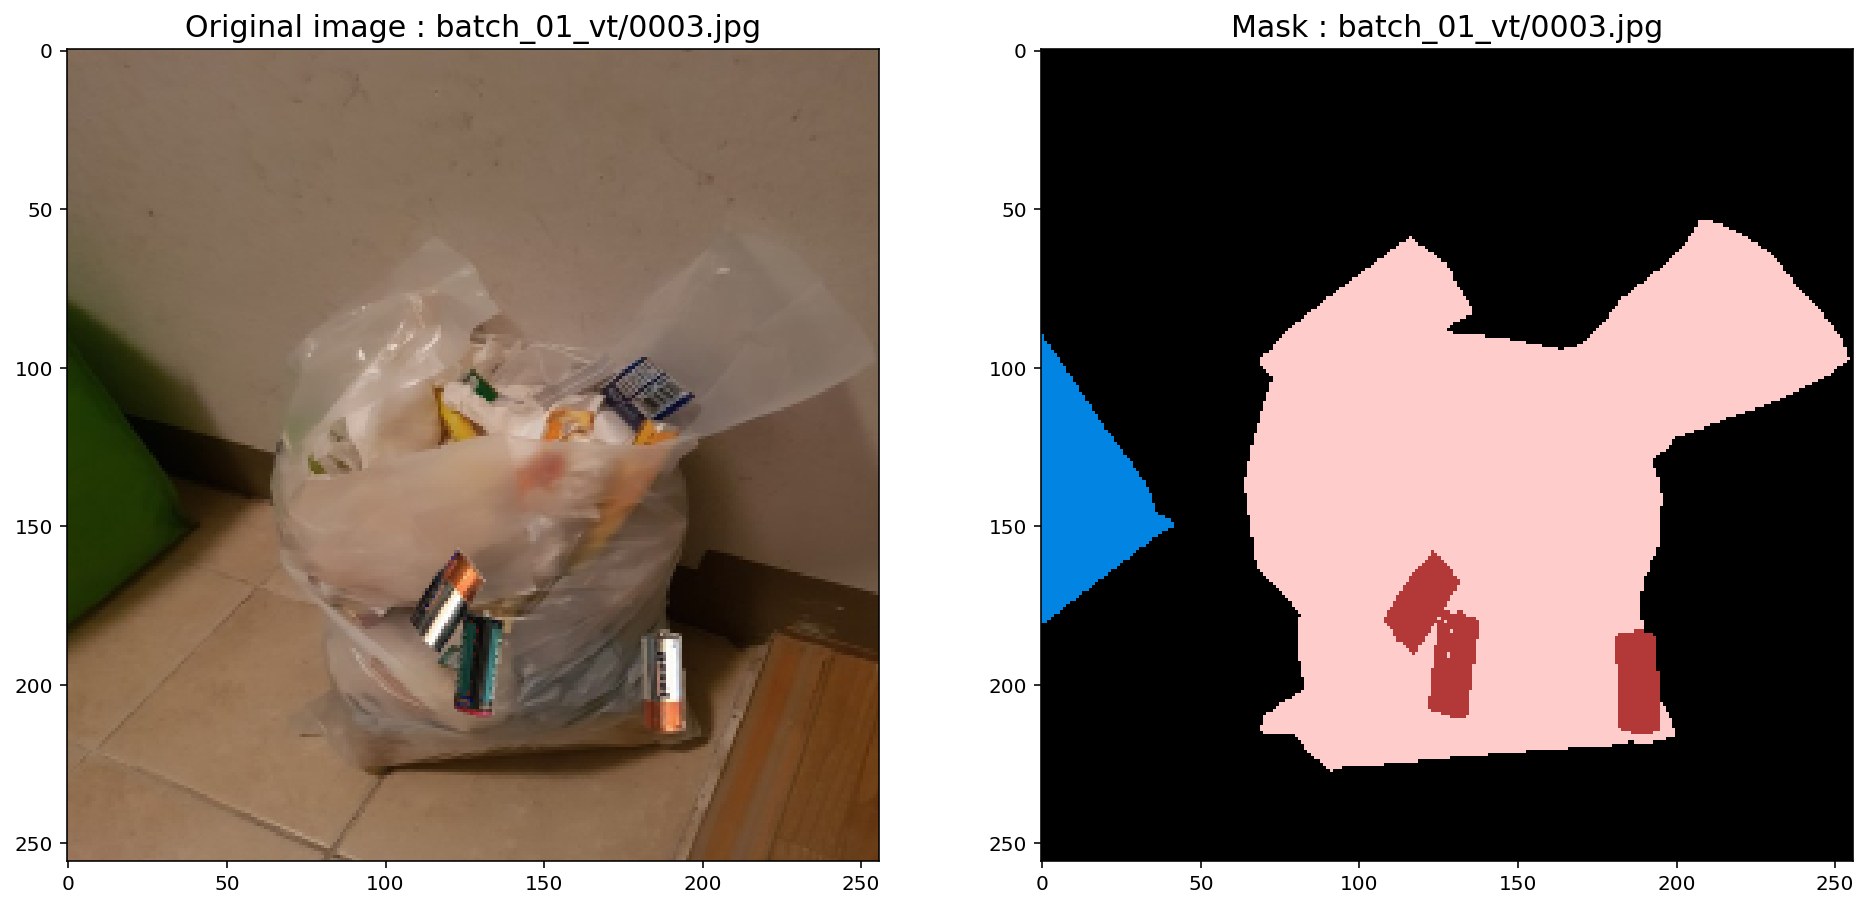

In [42]:
show_image(img, msk, info)

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


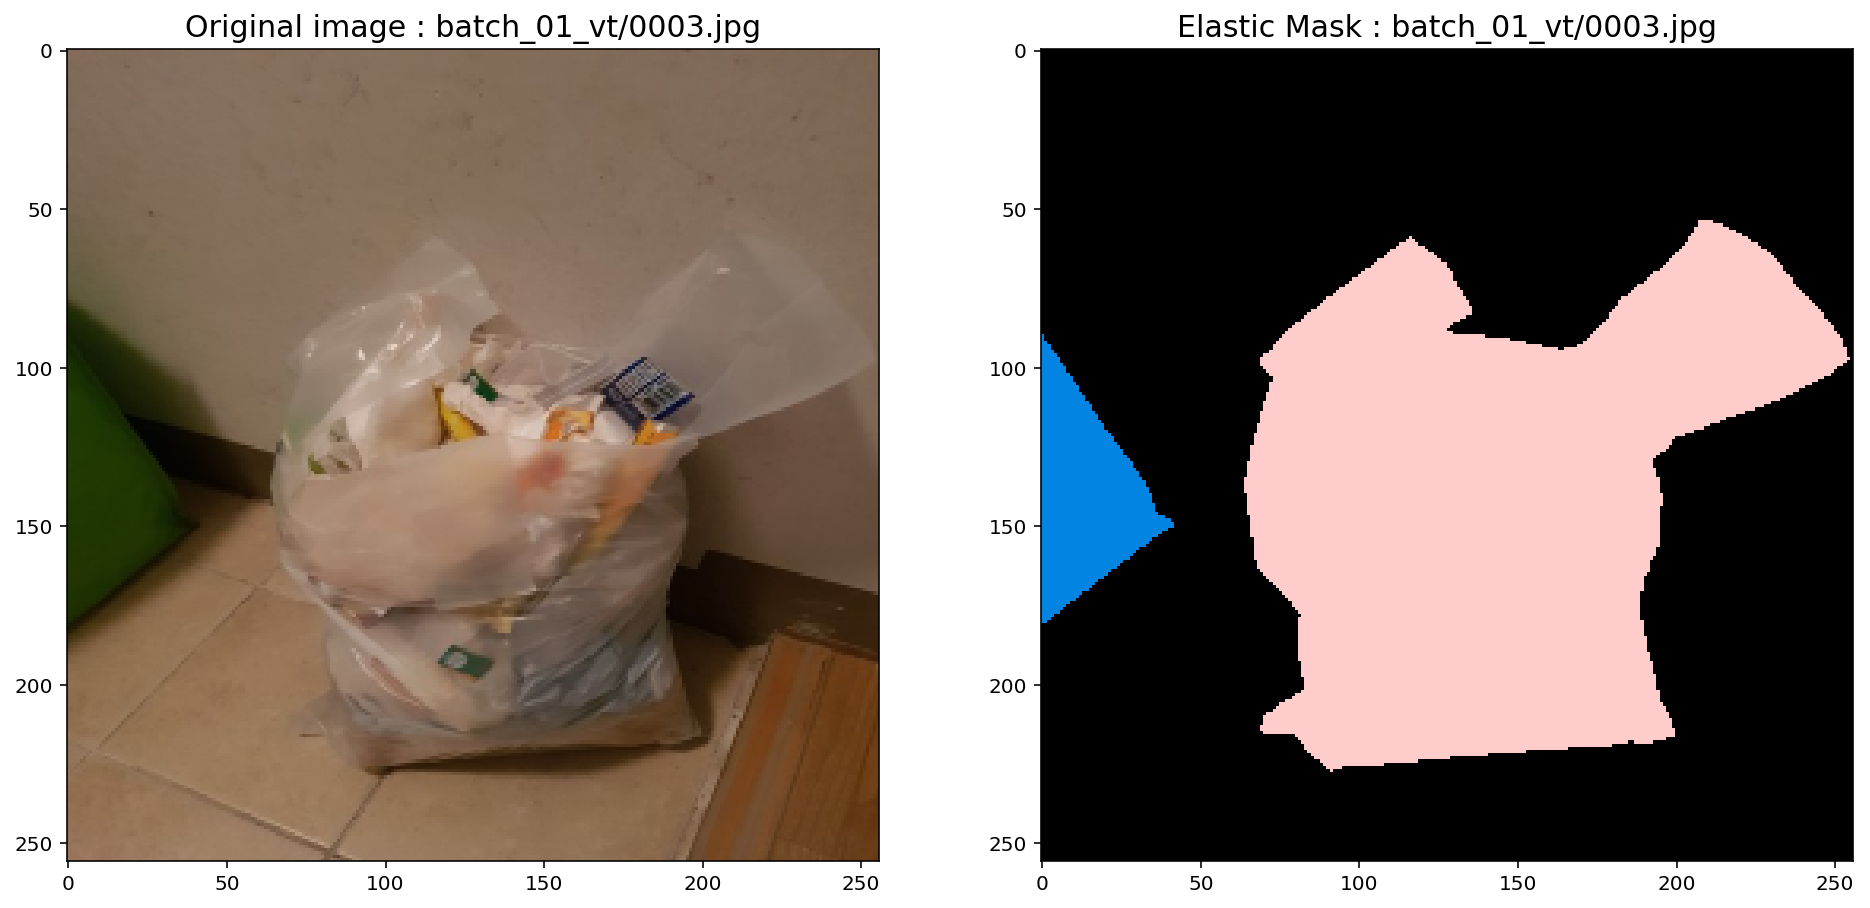

In [11]:
result = elastic_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Elastic")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


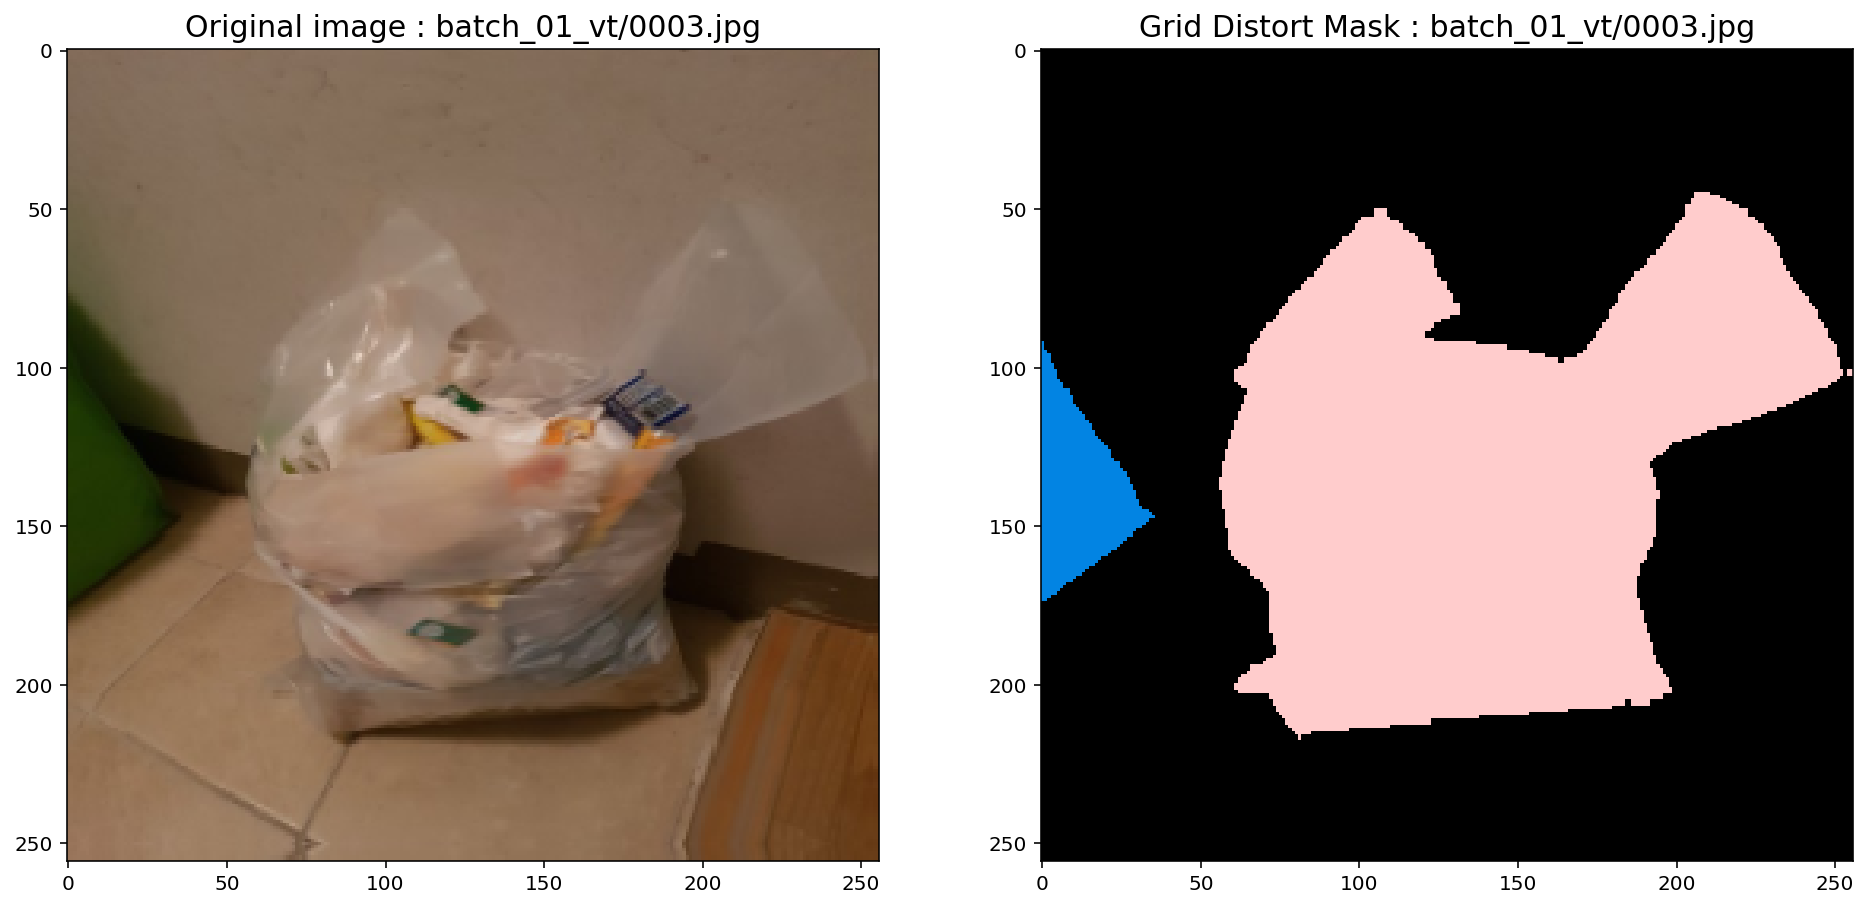

In [12]:
result = grid_distort_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Grid Distort")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


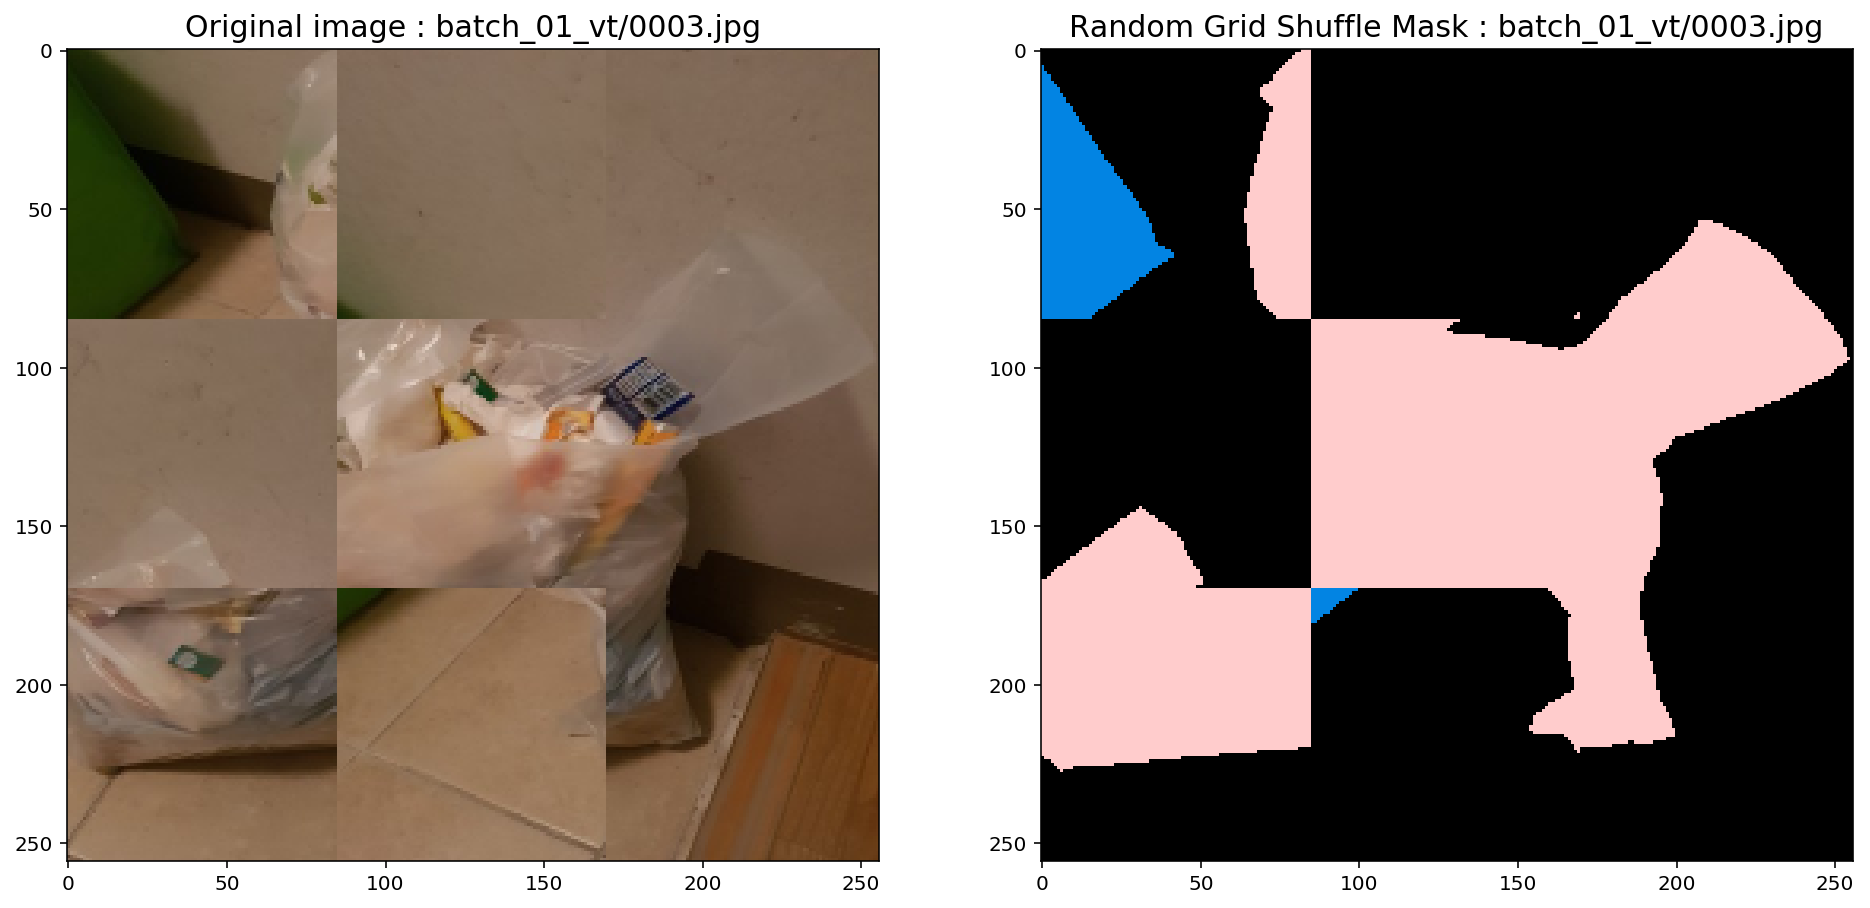

In [13]:
result = random_grid_shuffle_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Random Grid Shuffle")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


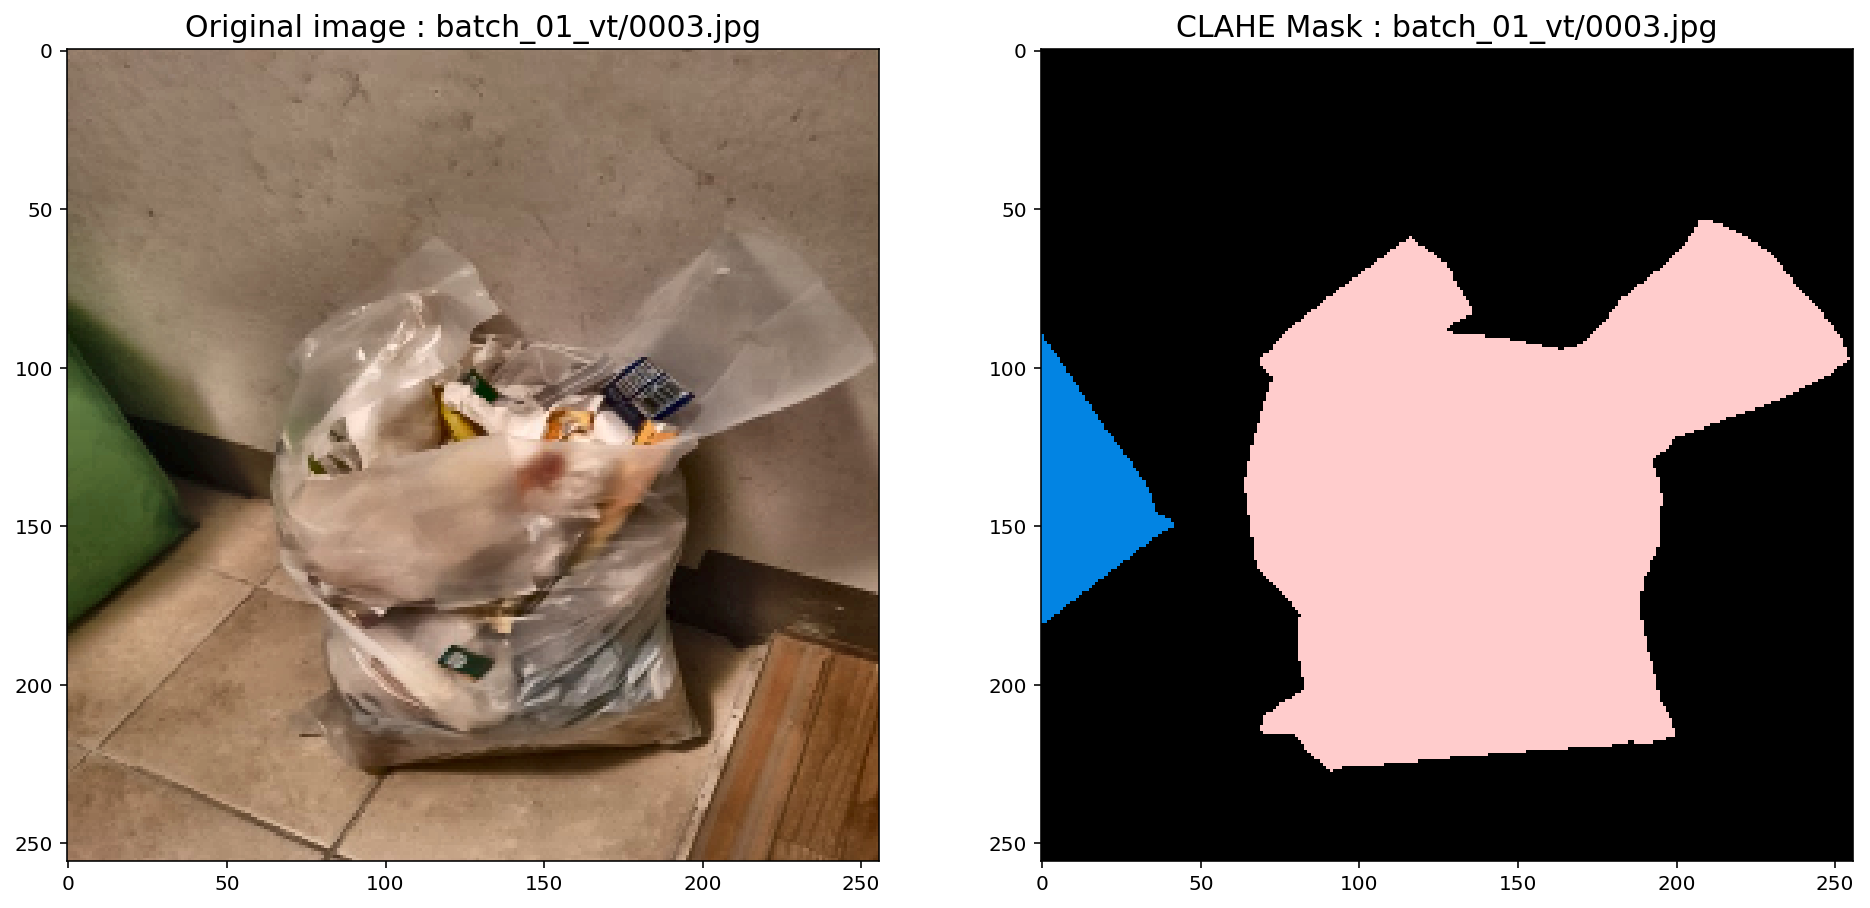

In [14]:
result = clahe_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="CLAHE")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


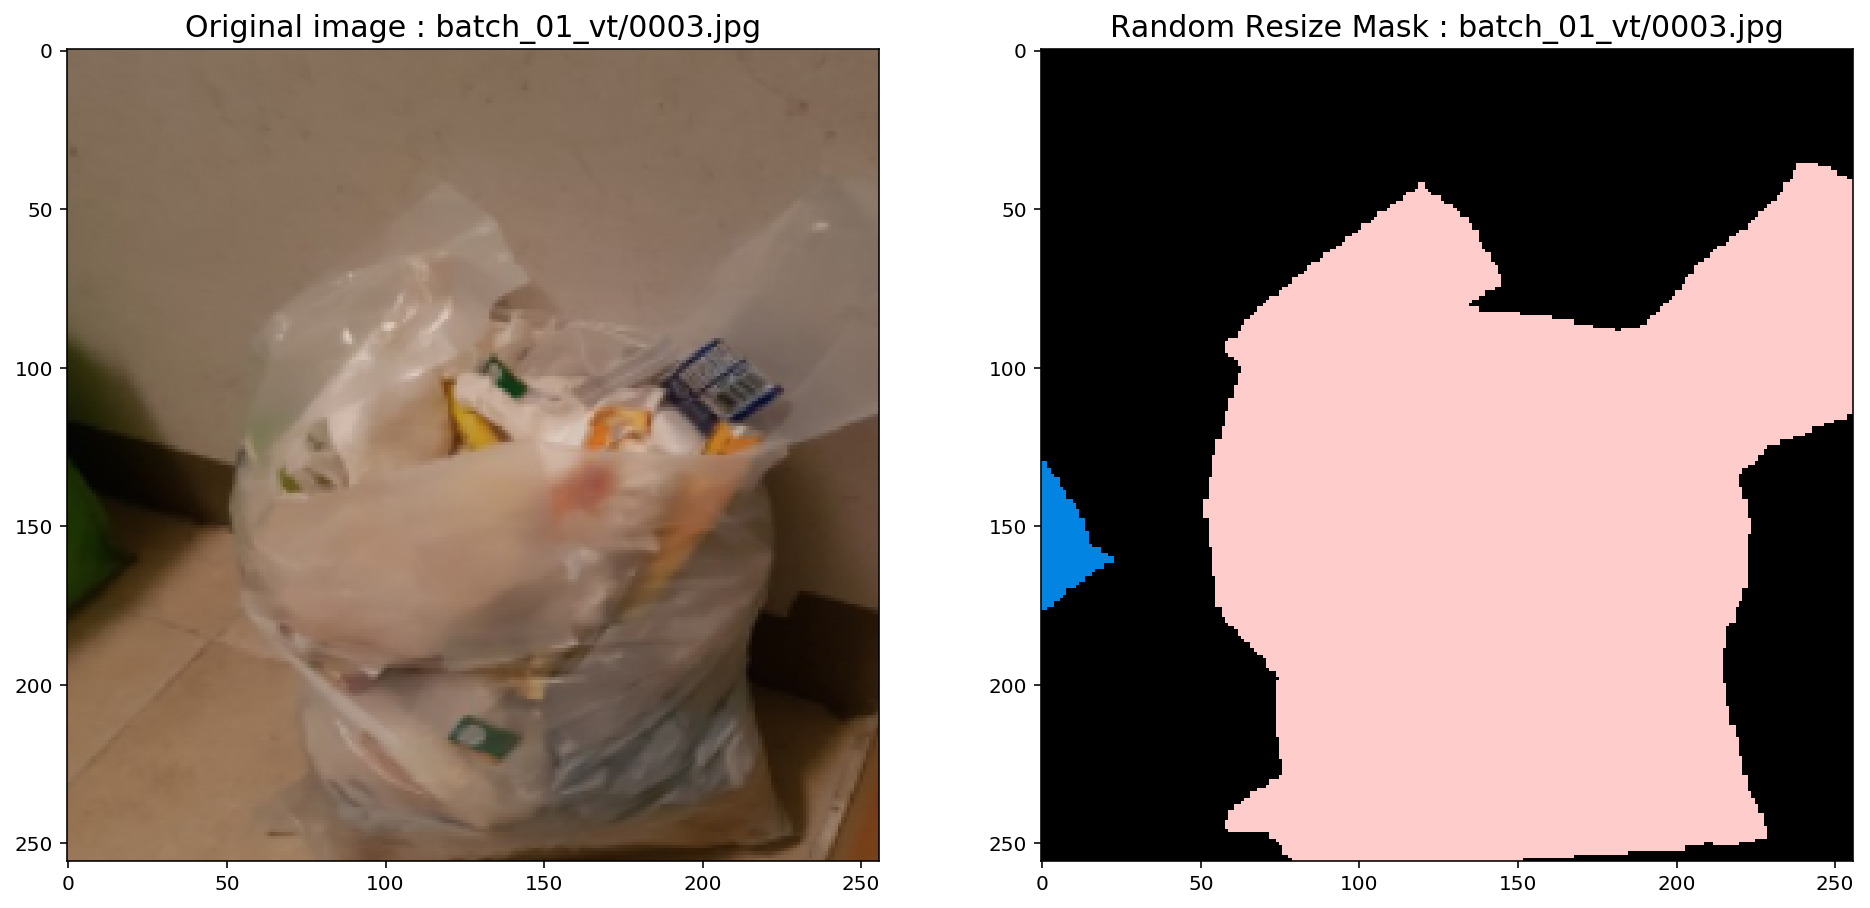

In [15]:
result = random_resize_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Random Resize")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


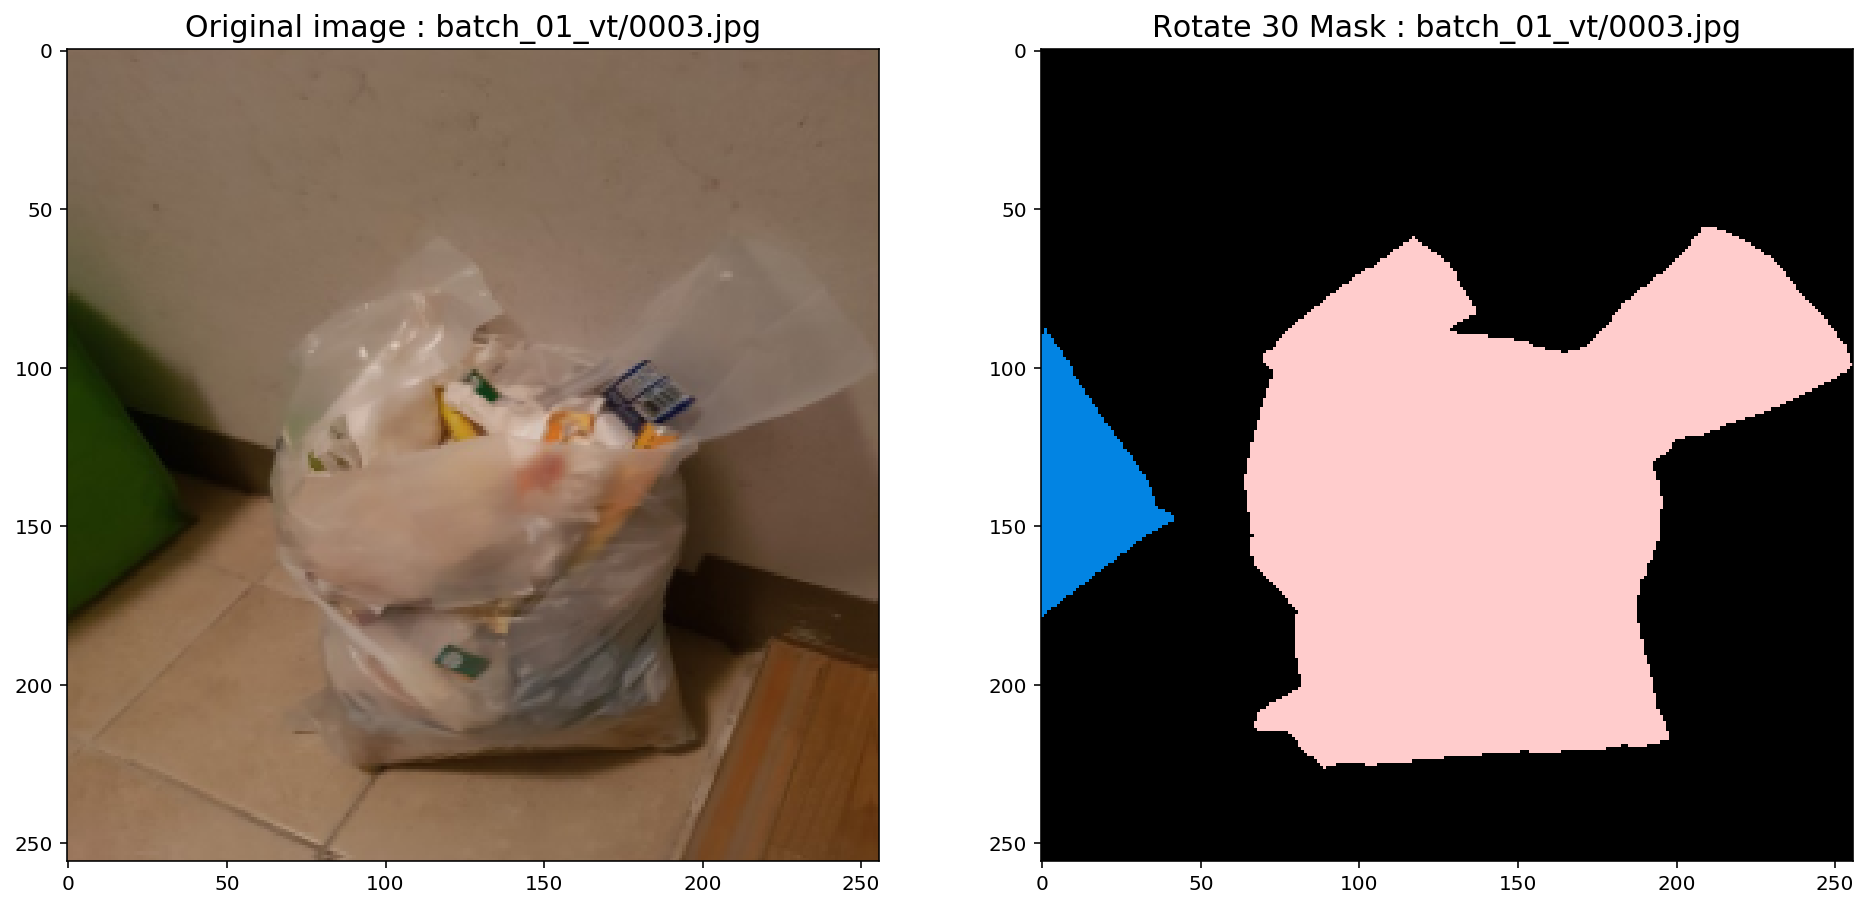

In [16]:
result = rotate_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Rotate 30")

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


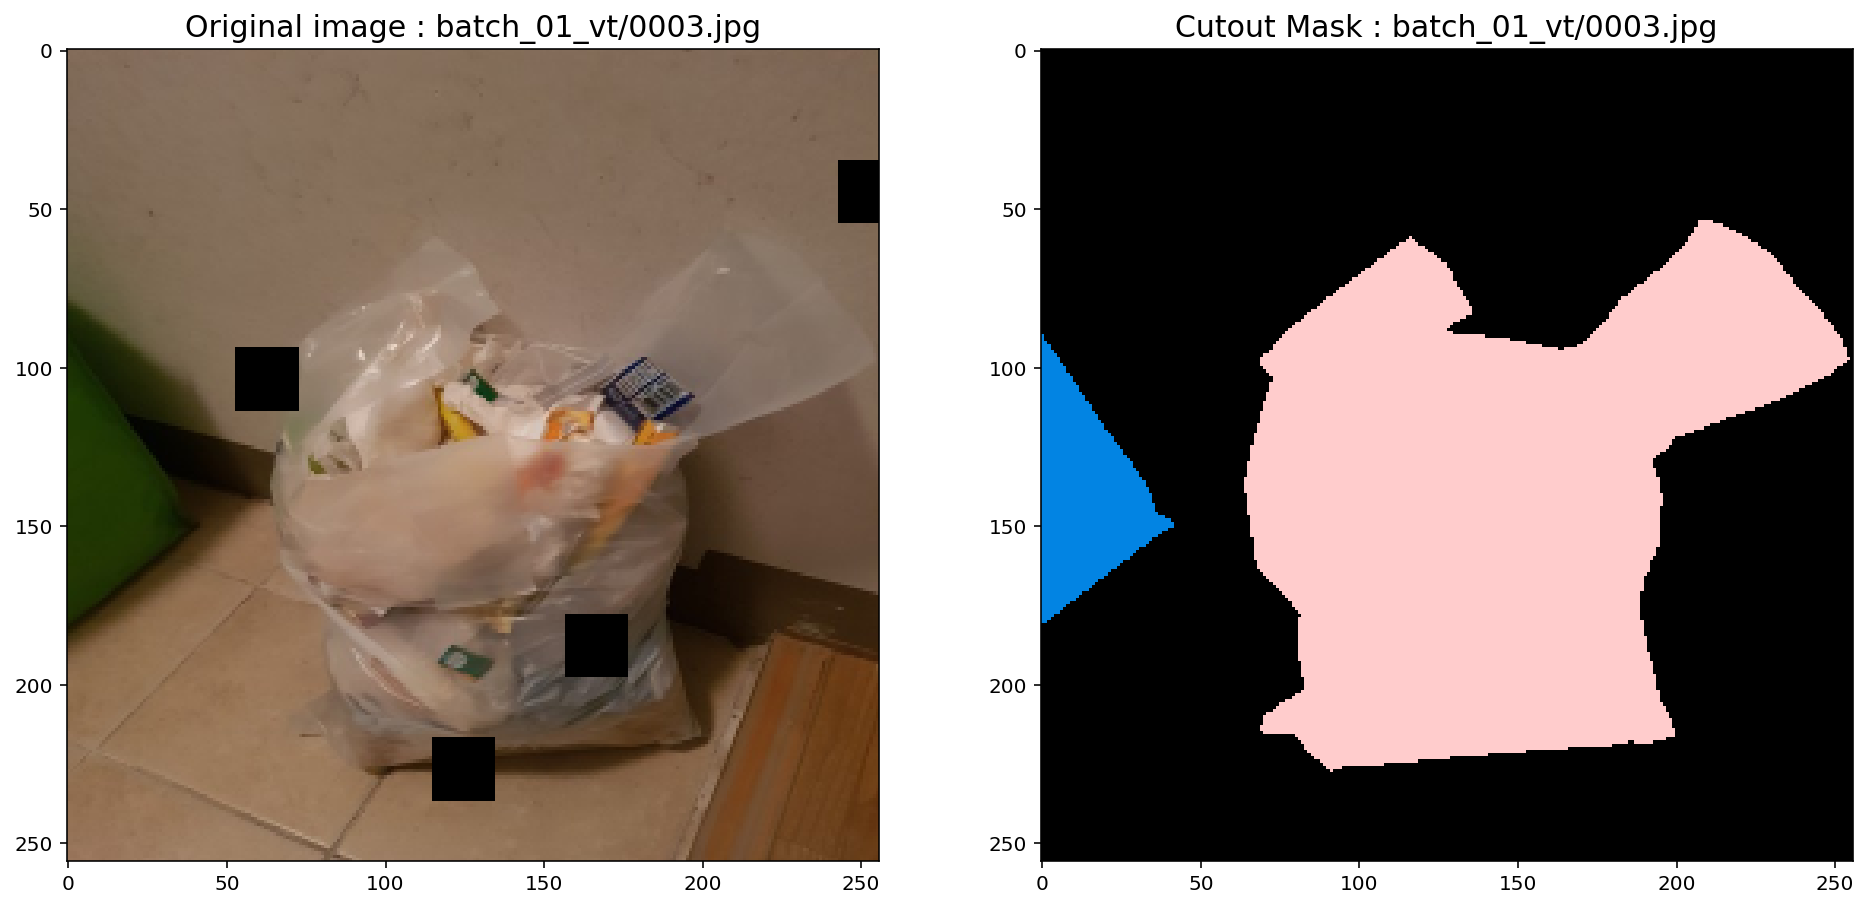

In [17]:
result = cutout_trfm(image=image.numpy(), mask=mask)
print(result['image'].shape, result['mask'].shape)

img = result['image']
msk = result['mask']
img = img.permute([1, 2, 0])

show_image(img, msk, info, name="Cutout")